In [1]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [28]:
import keras
from keras.models import Model
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Conv2D, Conv2DTranspose
from keras.constraints import max_norm
from keras import backend as K
import matplotlib.pyplot as plt
import numpy as np
from keras.layers import  Input,MaxPool2D, UpSampling2D, BatchNormalization, Activation
from keras.callbacks import EarlyStopping
from keras.optimizers import Adadelta
from keras import layers
import math
from skimage.measure import compare_psnr,compare_mse

In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 12s 0us/step


In [4]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


In [5]:
# Model configuration
img_width, img_height = 32, 32
batch_size = 32
no_epochs = 55
validation_split = 0.04
verbosity = 1
max_norm_value = 2.0
noise_factor = 0.25
number_of_visualizations = 10

In [6]:

x_train = x_train.reshape(x_train.shape[0],  img_width, img_height,3)
x_test = x_test.reshape(x_test.shape[0], img_width, img_height,3)


  

In [7]:
x_shape = (3 ,img_width, img_height)

In [8]:
# Parse numbers as floats
input_train = x_train.astype('float32')
input_test = x_test.astype('float32')

# Normalize data
input_train = input_train / 255
input_test = input_test / 255

input_train = np.clip(input_train, 0., 1.)   
input_test = np.clip(input_test, 0., 1.)


In [9]:
# x_train_line = np.copy(input_train)
# x_test_line = np.copy(input_test)

In [10]:
# Add noise
pure = input_train
pure_test = input_test
noise = np.random.normal(0, 1, pure.shape)
noise_test = np.random.normal(0, 1, pure_test.shape)
noisy_input = pure + noise_factor * noise
noisy_input_test = pure_test + noise_factor * noise_test

In [11]:

# x_train_line = drawLines(x_train_line)
# x_test_line = drawLines(x_test_line)

In [12]:
def showOrigDec(orig, noise, num=10):
    import matplotlib.pyplot as plt
    n = num
    plt.figure(figsize=(20, 4))

    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i+1)
        plt.imshow(orig[i].reshape(32, 32, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        # display noisy
        ax = plt.subplot(2, n, i +1 + n)
        plt.imshow(noise[i].reshape(32, 32, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

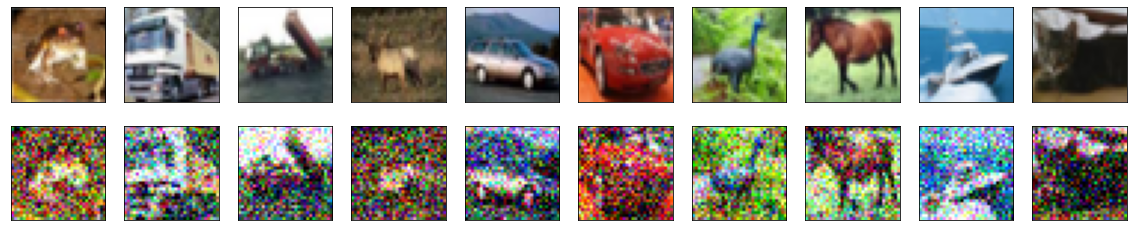

In [13]:
showOrigDec(pure, noisy_input)


In [14]:
# Create the model win%rb
Input_img=Input(shape=(32,32,3))
input_img = Input(shape=(32, 32, 3))
x = Conv2D(64, (7, 7), padding='same')(input_img)
x = BatchNormalization()(x)
x = Activation('relu')(x)
    
for i in range(3):
    x = Conv2D(64, (7, 7), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
x = Conv2D(3, (7, 7), padding='same')(x)
x = BatchNormalization()(x)
output_img = layers.add([x, input_img])


In [15]:
def psnr_metric(y_true,y_pred):
    mse = K.mean(K.square(y_pred - y_true), axis=-1)
    return -10*K.log(mse)/math.log(10)

In [18]:
model = Model(input_img, output_img)
model.compile(optimizer='adam', loss='mean_squared_error',metrics = ['accuracy',psnr_metric,'mean_squared_error'])

In [19]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 64)   9472        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 64)   256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 64)   0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [20]:
# Compile and fit data
# model.compile(optimizer='adam', loss='mean_squared_error')
es = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto', baseline=1)
model.fit(noisy_input, pure,
                epochs=no_epochs,
                batch_size=32,
                validation_split=validation_split,
          shuffle=True,
          callbacks=[es])

Train on 48000 samples, validate on 2000 samples
Epoch 1/55
48000/48000 [==============================] - 115s 2ms/step - loss: 0.1303 - accuracy: 0.4540 - psnr_metric: 14.8860 - mean_squared_error: 0.1303 - val_loss: 0.0075 - val_accuracy: 0.5828 - val_psnr_metric: 23.5024 - val_mean_squared_error: 0.0075
Epoch 2/55
48000/48000 [==============================] - 109s 2ms/step - loss: 0.0050 - accuracy: 0.6920 - psnr_metric: 26.0478 - mean_squared_error: 0.0050 - val_loss: 0.0058 - val_accuracy: 0.5928 - val_psnr_metric: 24.8345 - val_mean_squared_error: 0.0058
Epoch 3/55
48000/48000 [==============================] - 109s 2ms/step - loss: 0.0046 - accuracy: 0.7145 - psnr_metric: 26.6352 - mean_squared_error: 0.0046 - val_loss: 0.0052 - val_accuracy: 0.6500 - val_psnr_metric: 25.6329 - val_mean_squared_error: 0.0052
Epoch 4/55
48000/48000 [==============================] - 108s 2ms/step - loss: 0.0044 - accuracy: 0.7317 - psnr_metric: 27.0454 - mean_squared_error: 0.0044 - val_loss: 0

In [21]:
score = model.evaluate(pure_test, noisy_input_test, verbose=1)
print(score)


10000/10000 [==============================] - 7s 663us/step
[0.06583218528032303, 0.43497589230537415, 13.42430591583252, 0.06583216786384583]


In [22]:
# Generate denoised images
samples = noisy_input_test[:number_of_visualizations]
targets = input_test[:number_of_visualizations]
denoised_images = model.predict(samples)

In [30]:
def get_psnr_result(x_test, out):
    psnr_sum = 0
    for i in range(out.shape[0]):
        psnr_sum += compare_psnr(x_test[i].reshape(32,32,1),out[i].reshape(32,32,1),data_range=255)
        
    return 1.0*psnr_sum/out.shape[0];

In [23]:
def rgb2gray(rgb):

    r, g, b = rgb[:,:,:,0], rgb[:,:,:,1], rgb[:,:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray

In [26]:
samples1 = rgb2gray(samples)
print (samples1.shape)
denoised_images1 = rgb2gray(denoised_images)
print(denoised_images1.shape)

(10, 32, 32)
(10, 32, 32)


In [31]:
# print (compare_mse(samples[0].flatten(),(denoised_images[0]*255.).flatten()))
get_psnr_result(denoised_images1,samples1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
  after removing the cwd from sys.path.


64.13815714303804

In [32]:
def showOrigDec(orig, noise, denoised, num=10):
    import matplotlib.pyplot as plt
    n = num
    plt.figure(figsize=(20, 4))

    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i+1)
        plt.imshow(orig[i].reshape(32, 32, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        # display noisy
        ax = plt.subplot(2, n, i +1 + n)
        plt.imshow(noise[i].reshape(32, 32, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        #display denoise image
        ax = plt.subplot(2, n, i +1 + n)
        plt.imshow(denoised[i].reshape(32, 32, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RG

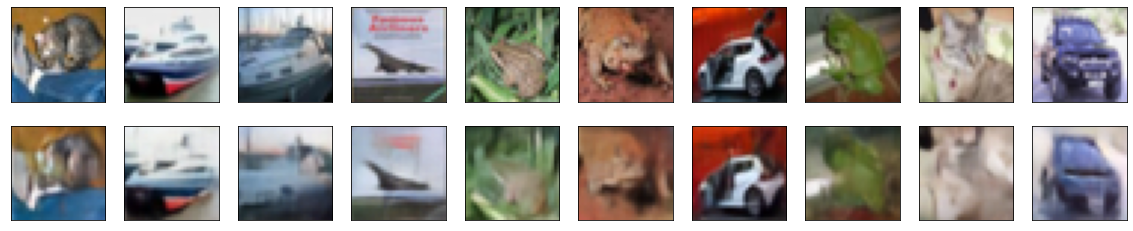

In [33]:
showOrigDec(input_test, samples, denoised_images)


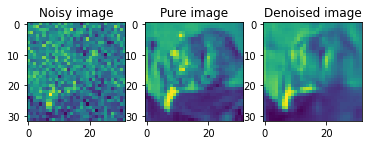

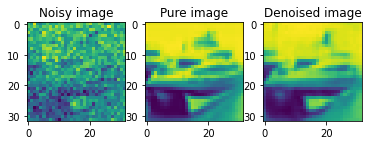

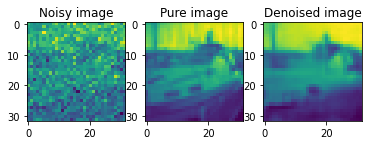

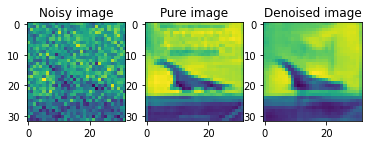

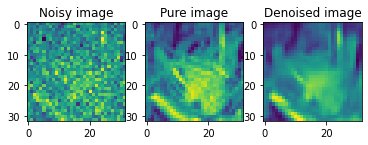

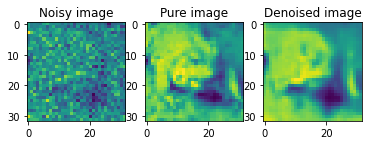

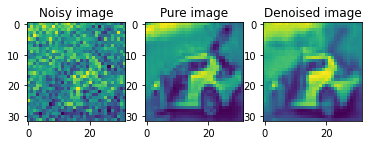

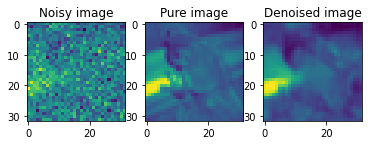

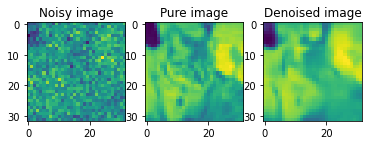

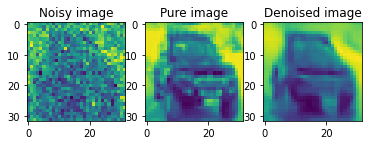

In [34]:
# Plot denoised images
for i in range(0, number_of_visualizations):
  # Get the sample and the reconstruction
  noisy_image = noisy_input_test[i][:, :, 0]
  pure_image  = input_test[i][:, :, 0]
  denoised_image = denoised_images[i][:, :, 0]
  input_class = targets[i]
  # Matplotlib preparations
  fig, axes = plt.subplots(1, 3)
  fig.set_size_inches(6, 3.5)
  # Plot sample and reconstruciton
  axes[0].imshow(noisy_image)
  axes[0].set_title('Noisy image')
  axes[1].imshow(pure_image)
  axes[1].set_title('Pure image')
  axes[2].imshow(denoised_image)
  axes[2].set_title('Denoised image')
  
  plt.show()